# Invocation Fees and Billing Granularities

In [1]:
import os
import json
import numpy as np
from matplotlib import pyplot as plt
import re
import math
import matplotlib.lines as mlines
from datetime import datetime
from dateutil import parser
import pickle
import pandas as pd
from collections import defaultdict
from collections import OrderedDict
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import matplotlib.patheffects as path_effects
from matplotlib.ticker import FormatStrFormatter
import os
import seaborn as sns
import gc

In [2]:
print("="*80)
print("Invocation Fees and Billing Granularities")
print("-"*80)

Invocation Fees and Billing Granularities
--------------------------------------------------------------------------------


In [3]:
# ensure figures dir exists
os.makedirs('figures', exist_ok=True)

## Serverless Prices

In [4]:
# AWS Lambda
P_LAMBDA_PER_GBS = 0.0000166667 # https://aws.amazon.com/lambda/pricing/ # CPU proportionally allocated. 1vCPU under 1769MB
P_LAMBDA_INVOCATION_FEE = 0.2 / 1000000

# GCP Cloud Run request-based
P_GCP_CPU_PER_VCPUSECOND = 0.00002400 # https://cloud.google.com/run/pricing
P_GCP_MEMORY_PER_GBSECOND = 0.00000250  # https://cloud.google.com/run/pricing
P_GCP_INVOCATION_FEE = 0.4 / 1000000 # https://cloud.google.com/run/pricing

# Azure Functions consumption plan
P_AZURE_COONSUMPTION_PER_GBS = 0.000016 # https://azure.microsoft.com/en-us/pricing/details/functions/
P_AZURE_FLEX_COONSUMPTION_PER_GBS = 0.000026 # https://azure.microsoft.com/en-us/pricing/details/functions/
P_AZURE_CONSUMPTION_INVOCATION_FEE = 0.2 / 1000000 # https://azure.microsoft.com/en-us/pricing/details/functions/
P_AZURE_FLEX_CONSUMPTION_INVOCATION_FEE = 0.4 / 1000000 # https://azure.microsoft.com/en-us/pricing/details/functions/
# Consumption plan is limited, typically to 1.5 GB of memory and one CPU

# IBM Code Engine Functions
P_IBM_CPU_PER_VCPUSECOND = 0.00003431 # https://cloud.ibm.com/containers/serverless/overview
P_IBM_MEMORY_PER_GBSECOND = 0.00000356 # https://cloud.ibm.com/containers/serverless/overview
P_IBM_INVOCATION_FEE = 0.538 / 1000000 # https://cloud.ibm.com/containers/serverless/overview

# Huawei FunctionGraph
P_HUAWEI_PER_GBS = 0.00001667 # https://www.huaweicloud.com/intl/en-us/pricing/calculator.html?tab=detail#/function
P_HUAWEI_INVOCATION_FEE = 0.2 / 1000000 # https://www.huaweicloud.com/intl/en-us/pricing/calculator.html?tab=detail#/function

# Alibaba Cloud Function Compute
P_ALIBABA_CPU_PER_VCPUSECOND = 1 * 0.000020 # https://www.alibabacloud.com/help/en/functioncompute/fc-2-0/product-overview/pay-as-you-go-billing-method?spm=a2c63.p38356.help-menu-2508973.d_0_3_3.26923fe1BiuSBt
P_ALIBABA_MEMORY_PER_GBSECOND = 0.15 * 0.000020 # https://www.alibabacloud.com/help/en/functioncompute/fc-2-0/product-overview/pay-as-you-go-billing-method?spm=a2c63.p38356.help-menu-2508973.d_0_3_3.26923fe1BiuSBt
P_ALIBABA_INVOCATION_FEE = 75/10,000* 0.000020 # https://www.alibabacloud.com/help/en/functioncompute/fc-2-0/product-overview/pay-as-you-go-billing-method?spm=a2c63.p38356.help-menu-2508973.d_0_3_3.26923fe1BiuSBt

# Oracle Cloud Functions
P_ORACLE_PER_GBS = 0.00001417 # https://www.oracle.com/ca-en/cloud/price-list/#pricing-containers
P_ORACLE_INVOCATION_FEE = 0.0000002

# Vercel Functions
P_VERCEL_PER_GBS = 0.18 / 3600 # https://vercel.com/docs/functions/usage-and-pricing
P_VERCEL_INVOCATION_FEE = 0.60 / 1000000

# Cloudflare Workers
P_CLOUDFLARE_CPU_PER_MS = 0.02 / 1000000 # https://developers.cloudflare.com/workers/platform/pricing/
P_CLOUDFLARE_INVOCATION_FEE = 0.3 / 1000000 # https://developers.cloudflare.com/workers/platform/pricing/

In [5]:
def calculate_aws_equivalent_ms(vcpus):
    mem = np.ceil(vcpus * 1769)
    mem_gb = mem / 1024
    equivalent_wall_time_ms = P_LAMBDA_INVOCATION_FEE / (P_LAMBDA_PER_GBS * mem_gb) * 1000
    return equivalent_wall_time_ms

In [6]:
print(f"On AWS Lambda, a fixed invocation fee of {P_LAMBDA_INVOCATION_FEE} is equivalent to {np.ceil(calculate_aws_equivalent_ms(128/1769))}ms of billable wall-clock time for a function with the default 128MB memory configuration.")

On AWS Lambda, a fixed invocation fee of 2.0000000000000002e-07 is equivalent to 96.0ms of billable wall-clock time for a function with the default 128MB memory configuration.


In [7]:
def caclulate_gcp_equivalent_ms(vcpus, memory_mb=512):
    equivalent_wall_time_ms = P_GCP_INVOCATION_FEE / (P_GCP_CPU_PER_VCPUSECOND * vcpus + P_GCP_MEMORY_PER_GBSECOND * memory_mb / 1024) * 1000
    return equivalent_wall_time_ms

In [8]:
def calculate_azure_equivalent_ms(vcpus=1, memory_mb=1.5*1024):
    equivalent_wall_time_ms = P_AZURE_CONSUMPTION_INVOCATION_FEE / P_AZURE_COONSUMPTION_PER_GBS * 1000
    return equivalent_wall_time_ms

In [9]:
def calculate_ibm_equivalent_ms(vcpus=0.25, memory_mb=512):
    equivalent_wall_time_ms = P_IBM_INVOCATION_FEE / (P_IBM_CPU_PER_VCPUSECOND * vcpus + P_IBM_MEMORY_PER_GBSECOND * memory_mb / 1024) * 1000
    return equivalent_wall_time_ms

In [10]:
def calculate_cloudflare_equivalent_ms(vcpus=0.25, memory_mb=512):
    equivalent_wall_time_ms = P_CLOUDFLARE_INVOCATION_FEE / P_CLOUDFLARE_CPU_PER_MS
    return equivalent_wall_time_ms

In [11]:
def calculate_vercel_equivalent_ms(vcpus): # too close to aws, ignore
    mem = np.ceil(vcpus * 1769)
    mem_gb = mem / 1024
    equivalent_wall_time_ms = P_VERCEL_INVOCATION_FEE / (P_VERCEL_PER_GBS * mem_gb) * 1000
    return equivalent_wall_time_ms

In [12]:
def calculate_huawei_equivalent_ms(memory_mb=512):
    equivalent_wall_time_ms = P_HUAWEI_INVOCATION_FEE / (P_HUAWEI_PER_GBS * memory_mb / 1024) * 1000
    return equivalent_wall_time_ms

## Read Traces

In [13]:
# Get trace data dir from CURRENT_DIR/../data.env
with open( '../data.env') as f:
    for line in f:
        if line.startswith('TRACE_DATA_DIR'):
            TRACE_DATA_DIR = line.split('=')[1].strip()
            break
TRACES_PATH = os.path.join(TRACE_DATA_DIR, 'public_request_tables')

In [14]:
TRACES_PATH = os.path.join(TRACES_PATH, 'huawei_25_traces_request_usage_rt.pkl')

In [15]:
with open(TRACES_PATH, "rb") as f:
    traces = pickle.load(f)

In [16]:
traces.shape

(947970744, 4)

In [17]:
execution_duration_data = traces[['runtimeCost']].copy()
memory_usage_data = traces[['runtimeCost', 'memory_usage']].copy()

In [18]:
execution_duration_data = execution_duration_data[execution_duration_data['runtimeCost'] >= 0.001].copy()
memory_usage_data = memory_usage_data[memory_usage_data['runtimeCost'] >= 0.001].copy()

In [19]:
print(f"Number of requests with execution times of at least 1ms: {execution_duration_data.shape[0]}")
print(f"Number of requests with execution times of at least 1ms: {memory_usage_data.shape[0]}")

Number of requests with execution times of at least 1ms: 527054654
Number of requests with execution times of at least 1ms: 527054654


## Plotting

In [20]:
vcpus_gcp = np.arange(0.08, 1.01, 0.001)
vcpus_aws = np.arange(0.072, 1.01, 0.001)

In [21]:
memory_usage_data.shape

(527054654, 2)

In [22]:
def cacluate_round_up_amount_simple_rounding_to_multiples(x, multiple):
    return math.ceil(x / multiple) * multiple - x

def calculate_round_up_amount_azure_consumption(et):
    # < 100ms, round up to 100ms
    # > 100ms, round up to the nearest 1ms
    if et <= 100:
        return 100 - et
    return 100 + math.ceil(et-100) - et

def calculate_round_up_memory_amount_azure_consumption(et_ms, memory_usage_mb):
    # < 100ms, round up to 100ms
    # > 100ms, round up to the nearest 1ms
    if et_ms <= 100:
        new_et_ms = 100
    else:
        new_et_ms = 100 + math.ceil(et_ms-100)
    billable_memory = math.ceil(memory_usage_mb / 128) * 128 * new_et_ms
    actual_billable_memory = memory_usage_mb * et_ms
    return billable_memory - actual_billable_memory

In [23]:
# calculate the round up amount for wall time billing granularity
round_up_amount_granularity_100ms = execution_duration_data['runtimeCost'].apply(lambda x: cacluate_round_up_amount_simple_rounding_to_multiples(x*1000, 100)) 
round_up_amount_azure_consumption = execution_duration_data['runtimeCost'].apply(lambda x: calculate_round_up_amount_azure_consumption(x*1000))

In [24]:
# calculate the round up amount for memory usage billing granularity

et_ms = memory_usage_data['runtimeCost'] * 1000

new_et_ms = np.where(
    et_ms <= 100,
    100,
    100 + np.ceil(et_ms - 100)
)

billable_memory = (np.ceil(memory_usage_data['memory_usage'] / 128) * 128) * new_et_ms

actual_billable = memory_usage_data['memory_usage'] * et_ms

round_up_memory_amount_azure_consumption = billable_memory - actual_billable

In [25]:
rounding_up = {
    "round_up_amount_granularity_100ms": round_up_amount_granularity_100ms,
    "round_up_amount_azure_consumption": round_up_amount_azure_consumption,
    "round_up_memory_amount_azure_consumption": round_up_memory_amount_azure_consumption
}

In [26]:
processed_data_dir = os.path.join(TRACE_DATA_DIR, 'processed_data')
os.makedirs(processed_data_dir, exist_ok=True)
processed_data_path = os.path.join(processed_data_dir, 'rounding_up.pkl')

In [27]:
with open(processed_data_path, "wb") as f:
    pickle.dump(rounding_up, f)

In [28]:
round_up_amount_azure_consumption = np.array(round_up_amount_azure_consumption)

/tmp/ipykernel_749863/4286869778.py:59: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.12)


Figure saved to figures/equivalent_wall_time_and_rounding_up.pdf


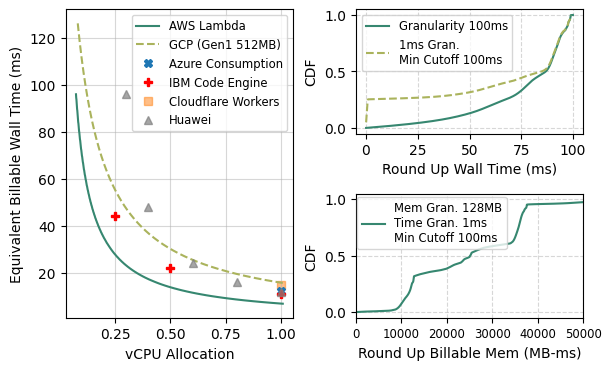

In [29]:
fig = plt.figure(figsize=(6, 3.6), constrained_layout=True)
gs = fig.add_gridspec(2, 2,
                      width_ratios=[1, 1],
                      height_ratios=[1, 1])

palette = sns.color_palette("gist_earth", n_colors=2)
linestyle_list = ['-', '--']

def fast_cdf(data, nbins=1000):
    counts, bin_edges = np.histogram(data, bins=nbins)
    cdf = np.cumsum(counts) / counts.sum()
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return bin_centers, cdf

ax1 = fig.add_subplot(gs[:, 0])
aws_equivalent_ms = calculate_aws_equivalent_ms(vcpus_aws)
ax1.plot(vcpus_aws, aws_equivalent_ms, label='AWS Lambda', color=palette[0], linestyle='-')
ax1.plot(vcpus_gcp, caclulate_gcp_equivalent_ms(vcpus_gcp), label='GCP (Gen1 512MB)', color=palette[1], linestyle='--')
ax1.plot(1, calculate_azure_equivalent_ms(), 'X', label='Azure Consumption')
for cpu,mem in [(0.25,1024),(0.5,2048),(1,4096)]:
    ax1.plot(cpu, calculate_ibm_equivalent_ms(cpu, mem), 'P', color='red',
             label='IBM Code Engine' if cpu==0.25 else "")
ax1.plot(1, calculate_cloudflare_equivalent_ms(), 's',
         label='Cloudflare Workers', alpha=0.5, zorder=0)
for alloc,mem in [(0.3,128),(0.4,256),(0.6,512),(0.8,768),(1,1024)]:
    ax1.plot(alloc, calculate_huawei_equivalent_ms(mem), '^',
             color='grey', alpha=0.7, label='Huawei' if alloc==0.3 else "")
ax1.set_xlabel('vCPU Allocation')
ax1.set_ylabel('Equivalent Billable Wall Time (ms)')
ax1.legend(fontsize="small")
ax1.grid(alpha=0.5)

ax2 = fig.add_subplot(gs[0, 1])
i = 0
for label, series in [
    ('Granularity 100ms', round_up_amount_granularity_100ms),
    ('1ms Gran.\nMin Cutoff 100ms', round_up_amount_azure_consumption),
]:
    x, y = fast_cdf(series, nbins=500)
    ax2.plot(x, y, label=label, color=palette[i], linestyle=linestyle_list[i])
    i += 1
ax2.set_xlabel('Round Up Wall Time (ms)')
ax2.set_ylabel('CDF')
ax2.legend(fontsize="small")
ax2.grid(alpha=0.5, linestyle='--')

ax3 = fig.add_subplot(gs[1, 1])
mem_arr = np.array(round_up_memory_amount_azure_consumption)
idx = np.random.choice(len(mem_arr), size=1_000_000, replace=False)
sample = np.sort(mem_arr[idx])
cdf = np.arange(1, sample.size + 1) / sample.size
ax3.plot(sample, cdf, label='Mem Gran. 128MB\nTime Gran. 1ms\nMin Cutoff 100ms', color=palette[0])
ax3.set_xlabel('Round Up Billable Mem (MB-ms)')
ax3.set_ylabel('CDF')
ax3.set_xlim(0, 0.5e5)
ax3.legend(fontsize="small", loc='upper left', bbox_to_anchor=(-0.02, 1.02))
ax3.grid(alpha=0.5, linestyle='--')
plt.setp(ax3.get_xticklabels(), rotation=0, fontsize="small")
fig.subplots_adjust(bottom=0.12)

fig.savefig('figures/equivalent_wall_time_and_rounding_up.pdf')
print("Figure saved to figures/equivalent_wall_time_and_rounding_up.pdf")

In [30]:
print(f"Average rounded-up wall time with the 100ms billing granularity: {np.mean(round_up_amount_granularity_100ms.values):.3f}ms")

Average rounded-up wall time with the 100ms billing granularity: 77.118ms


In [31]:
print(f"Average rounded-up wall time with the 1ms granularity and 100ms minimum cutoff: {np.mean(round_up_amount_azure_consumption):.3f}ms")

Average rounded-up wall time with the 1ms granularity and 100ms minimum cutoff: 61.350ms


In [32]:
print(f"Average rounded-up billable memory with the 128MB granularity: {np.mean(round_up_memory_amount_azure_consumption/1000/1024):.5f}GB-seconds")

Average rounded-up billable memory with the 128MB granularity: 0.02669GB-seconds


In [33]:
print(f"Average execution duration reported in the trace: {np.mean(traces['runtimeCost'])*1000:.2f}ms")

Average execution duration reported in the trace: 58.19ms


In [34]:
print(f"Average billable memory amounts reported in the trace: {np.mean(traces['runtimeCost'] * traces['memory_usage'] /1024)}GB-seconds")

Average billable memory amounts reported in the trace: 0.02746200304839938GB-seconds
